# Подсчет неопределенности метрик

## Оценка метрики качества модели

Ожидаемый результат работы модели детекции аномалий формулируется следующим образом: классификатор $\phi$ по входному изображению $x$ возвращает значение $\phi(x) \in [0, 1]$, которое интерпретируется как степень уверенности в наличии археологического объекта. Чем ближе значение $\phi(x)$ к единице, тем выше уверенность модели в наличии аномалии.

Для получения бинарного предсказания используется пороговое значение $\rho \in [0, 1]$. Если предсказание модели превышает порог, изображение классифицируется как содержащее археологическую аномалию (класс 1); в противном случае — как неаномальное (класс 0):

$$
\text{class}(x) = 
\begin{cases}
1, & \phi(x) > \rho \\
0, & \phi(x) \leq \rho
\end{cases}
$$

Такое использование классификатора можно интерпретировать как применение статистического критерия проверки гипотез, где:
- Нулевая гипотеза $H_0$: на изображении нет археологической аномалии
- Альтернативная гипотеза $H_1$: на изображении есть археологическая аномалия



Пара $(\phi, \rho)$ задаёт статистический критерий, где $\phi$ играет роль тестовой статистики, а $\rho$ — критического значения. В этом контексте возможны два типа ошибок:
- Ошибка первого рода: классификатор выдаёт $1$ (аномалия обнаружена), хотя изображение нормальное (ложноположительное срабатывание)
- Ошибка второго рода: классификатор выдаёт $0$ (аномалия не обнаружена), хотя на изображении она присутствует (ложноотрицательное срабатывание)


Как будет описано в разделе *Данные*,
в нашем распоряжении имеется небольшой набор размеченных снимков,
достоверно содержащих археологические объекты $A_1$.
Из него выделяется подмножество изображений $A_2$,
на которых объект крупный и хорошо различим.
Эти данные используются в качестве *валидационного датасета (выборки)*:
аномалии, похожие на те, что предоставлены в них, мы стремимся обнаружить.



Зафиксируем одну из таких выборок и обозначим её как $A$. Порог $\rho$ подбирается так, чтобы эмпирическая оценка ошибки второго рода,
вычисленная на этой выборке, не превышала заданного значения $\beta$:

$$
\mathbb{P} (\phi (x) \le \rho | H_1) \approx \frac{1}{|A|} \sum_{x \in A} \mathbb{I}[\phi(x) \leq \rho] \leq \beta.
$$

При фиксированной $\beta$ - или,
что то же самое, при фиксированной нижней границе *мощности* критерия $1 - \beta$ - мы стремимся минимизировать количество ложных срабатываний классификатора на фоновых изображениях пустыни, то есть минимизировать оценку ошибки первого рода $\alpha$,

$$
\alpha := \frac{1}{|D|} \sum_{x \in D} \mathbb{I}[\phi(x) > \rho] \approx \mathbb{P} (\phi (x) > \rho | H_0)  ,
$$

где $D$ — случайная подвыборка спутниковых снимков пустынной местности, для которых наличие аномалий неизвестно,  и которые с большой вероятностью принадлежат к нулевому классу (не содержат археологических объектов).

Заметим, что, в отличие от классического случая применения статистических критериев, нам недоступны распределения $\phi(\cdot | H_0)$ и $\phi(\cdot | H_1)$. Вместо этого мы располагаем выборками $D$ и $A$, соответственно отражающими нулевую и альтернативную гипотезы. Поэтому ошибки первого и второго рода оцениваются эмпирически на этих выборках. На рисунке ниже визуально показан смысл ошибок первого и второго рода в терминах распределений.

Мы можем оценить качество классификатора, а также сравнить между собой качество нескольких различных классификаторов с помощью следующей метрики:

$$
\tau := 1 - \alpha = \frac{1}{|D|} \sum_{x \in D} \mathbb{I}[\phi(x) \leq \rho] \approx \mathbb{P} (\phi (x) \le \rho | H_0) ,
$$

Таким образом, при заданной допустимой ошибке второго рода $\beta$, задача сводится к максимизации метрики $\tau$, то есть к минимизации количества ложноположительных срабатываний. 


Интерпретация метрики $\tau$ такова: это доля изображений, отнесённых моделью к неаномальному классу, - иначе говоря, доля снимков, которые можно исключить из рассмотрения при проведении ручного анализа. Чем выше значение $\tau$, тем меньше изображений потребуется проверить вручную при сохранении заданной чувствительности модели

В работе мы будем проводить сравнение моделей на обоих валидационных датасетах, используя фиксированную ошибку второго рода $\beta = 0.2$. Данный выбор не слишком сильной мощности классификатора связан с тем, что не на всех снимках даже отобранного валидационного датасета аномалии явно видны, а в ряде случаев наличие объекта остаётся спорным даже для экспертов в области археологии.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

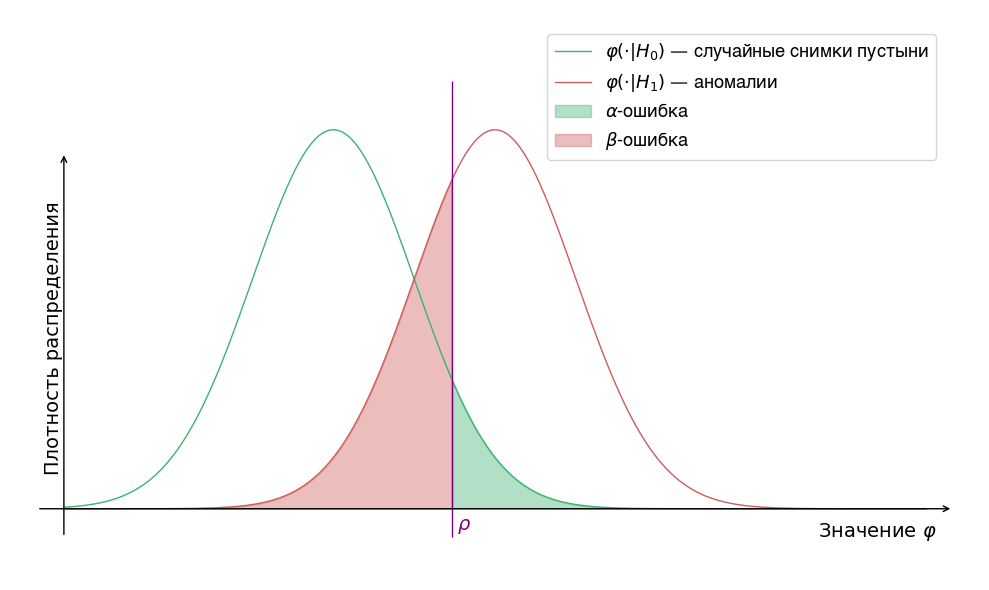

In [2]:
x = np.linspace(-8, 8, 1000)

LOC0 = -3
LOC1 = 0
SCALE = 1.5

pdf_H0 = norm.pdf(x, loc=LOC0, scale=SCALE)  # Случайные снимки пустыни
pdf_H1 = norm.pdf(x, loc=LOC1, scale=SCALE)   # Аномалии
threshold = -0.8


fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlim(-9, 9)
ax.set_ylim(-0.05, 0.35)

# Основные линии
ax.plot(x, pdf_H0, label=r'$\varphi(\cdot | H_0)$ — случайные снимки пустыни', color='mediumseagreen', lw=1)
ax.plot(x, pdf_H1, label=r'$\varphi(\cdot | H_1)$ — аномалии', color='indianred', lw=1)

# Закрашенные области ошибок
x_fill_type1 = x[x > threshold]
ax.fill_between(x_fill_type1, 0, norm.pdf(x_fill_type1, loc=LOC0, scale=SCALE), color='mediumseagreen', alpha=0.4, label=r'$\alpha$-ошибка')

x_fill_type2 = x[x < threshold]
ax.fill_between(x_fill_type2, 0, norm.pdf(x_fill_type2, loc=LOC1, scale=SCALE), color='indianred', alpha=0.4, label=r'$\beta$-ошибка')

# Вертикальная линия rho
ax.vlines(threshold, ymin=-0.02, ymax=0.3, color='purple', linestyle='-', lw=1)
ax.text(threshold + 0.1, -0.015, r'$\rho$', fontsize=14, color='purple')

# Удаление всех стандартных осей и меток
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)


# Добавление пользовательских осей с стрелками
# Добавление горизонтальной оси (φ)
ax.annotate('', xy=(8.5, 0), xytext=(-8.5, 0), arrowprops=dict(arrowstyle='->', lw=1, color='black'))
ax.text(6.0, -0.02, r'Значение $\varphi$', fontsize=14, ha='left')

# Добавление вертикальной оси (плотность распределения)
ax.annotate('', xy=(-8.0, 0.25), xytext=(-8.0, -0.02), arrowprops=dict(arrowstyle='->', lw=1, color='black'))
ax.text(-8.2, 0.12, 'Плотность распределения', fontsize=14, rotation=90, va='center', ha='center')

plt.rcParams['font.family'] = 'Helvetica'

# ax.set_facecolor('#f0f2ef')

# Легенда и отображение
fig.legend(bbox_to_anchor=(0.95, 0.95), fontsize=13)
plt.tight_layout()
plt.show()

## Оценка неопределенности метрики $\tau$

Итак, метрика качества классификатора $\tau$ подсчитывается на датасете фоновых снимков пустныи $D$: 

$$
\tau = \frac{1}{|D|} \sum_{x \in D} \mathbb{I}[\phi(x) \leq \rho] \approx \mathbb{P} (\phi (x) \le \rho | H_0)
$$


Поскольку такое вычисление метрики неточно, переобозначим в соответствии с принятыми в области статистики обозначениями

$$
\tau = \mathbb{P} (\phi (x) \le \rho | H_0) 
$$
истинную метрику качества классификатора, а 

$$
\hat{\tau} = \frac{1}{|D|} \sum_{x \in D} \mathbb{I}[\phi(x) \leq \rho] 
$$
оценку этой метрики на датасете.

Обозначим за $n = |D|$ размер датасета неаномальных снимков.

Оценку $\hat{\tau}$ можно рассматривать как выборочное среднее от независимых Бернуллиевских случайных величин,
каждая из которых равна $1$, если модель правильно отнесла снимок из $D$ к неаномальному классу $H_0$, и $0$ - если ошиблась.

То есть, рассмотрим выборку независимых одинаково распределенных Бернуллевских случайных величин $\{X_i\}$, $i = 1, ..., n$,
$$
X_i = 
\begin{cases}
0, & \phi(x_i) > \rho \\
1, & \phi(x_i) \leq \rho
\end{cases}
$$

Тогда 
$$
\hat{\tau} = \frac{1}{n}\sum_{i=1}^{n}{X_i}
$$
выборочная доля успехов в серии Бернуллевских испытаний.



В этом случае имеем 
$$
\mathbb{E}[\hat{\tau}] = \tau
$$

$$
\mathbb{D}[\hat{\tau}] = \frac{\tau \cdot (1 - \tau)}{n}
$$


Поскольку $n$ достаточно велико ($>30$ для всех наших моделей), можно приближать распределение $\hat{\tau}$ нормальным c такмими средним и дисперсией.
В этом случае имеем оценку дисперии
$$
\hat{s} = \sqrt{\frac{\hat{\tau} \cdot (1 - \hat{\tau})}{n}}
$$
и можем построить $95\%$ доверительный интервал ($\alpha = 0.05$)
$$
CI = \hat{\tau} \pm z_{1-\frac{\alpha}{2}} \cdot \hat{s}
$$
где $z_{1-\frac{\alpha}{2}}$ - соответсвтующий квантиль нормального распределения.


In [3]:
import scipy.stats as ss

In [4]:
def compute_ci(mean_hat, n):
    s_hat = np.sqrt((mean_hat * (1 - mean_hat)) / n)
    z = ss.norm.ppf(0.975)
    return mean_hat - z * s_hat, mean_hat + z * s_hat

Значения оценки $\hat{\tau}$ и размеры датасетов:

| Подход              | $\hat{\tau}$ на $A_1$ | $n$ на $A_1$ | $\hat{\tau}$ на $A_2$ | $n$ на $A_2$ |
| ------------------- | --------------------- | ------------ | --------------------- | ------------ |
| Классификационный   | 0.21                  | 165          | 0.14                  | 49           |
| VQ_64_04 + ViT2     | 0.31                  | 99254        | 0.34                  | 99254        |
| VQ_64_04 + MaxDiff  | 0.46                  | 99254        | 0.56                  | 99254        |
| VQ_64_04 + MaxDiffQ | 0.50                  | 99254        | 0.53                  | 99254        |
| VQ_08_08 + ViT2     | 0.30                  | 99254        | 0.30                  | 99254        |
| VQ_08_08 + MaxDiff  | 0.46                  | 99254        | 0.51                  | 99254        |
| VQ_08_08 + MaxDiffQ | 0.47                  | 99254        | 0.53                  | 99254        |
| VQ_16_08 + ViT2     | 0.27                  | 99254        | 0.28                  | 99254        |
| VQ_16_08 + MaxDiff  | 0.43                  | 99254        | 0.45                  | 99254        |
| VQ_16_08 + MaxDiffQ | 0.43                  | 99254        | 0.46                  | 99254        |


In [5]:
import pandas as pd

In [6]:
d = {
    'Классификационный': [0.21, 165, 0.14, 49],

    'VQ_08_08 + ViT2': [0.30, 99245, 0.30, 99245],
    'VQ_64_04 + ViT2': [0.31, 99254, 0.34, 99254],
    'VQ_16_08 + ViT2': [0.27, 99245, 0.28, 99245],

    'VQ_64_04 + MaxDiff': [0.46, 99254, 0.56, 99254],
    'VQ_08_08 + MaxDiff': [0.46, 99254, 0.51, 99254],
    'VQ_16_08 + MaxDiff': [0.43, 99254, 0.45, 99254],


    'VQ_64_04 + MaxDiffQ': [0.50, 99254, 0.53, 99254],
    'VQ_08_08 + MaxDiffQ': [0.47, 99254, 0.53, 99254],
    'VQ_16  _08 + MaxDiffQ': [0.43, 99254, 0.46, 99254],
}

In [7]:
lst = []
for method, (tau1, n1, tau2, n2) in d.items():
    ci1_low, ci1_high = compute_ci(tau1, n1)
    lst.append({
        'Model': method,
        'Dataset': 'A1',
        'Tau': tau1,
        'CI_low': ci1_low,
        'CI_high': ci1_high
    })
    ci2_low, ci2_high = compute_ci(tau2, n2)
    lst.append({
        'Model': method,
        'Dataset': 'A2',
        'Tau': tau2,
        'CI_low': ci2_low,
        'CI_high': ci2_high
    })
data = pd.DataFrame(lst)

In [8]:
data

,Model,Dataset,Tau,CI_low,CI_high
0,Классификационный,A1,0.21,0.147852,0.272148
1,Классификационный,A2,0.14,0.042845,0.237155
2,VQ_08_08 + ViT2,A1,0.30,0.297149,0.302851
3,VQ_08_08 + ViT2,A2,0.30,0.297149,0.302851
4,VQ_64_04 + ViT2,A1,0.31,0.307123,0.312877
5,VQ_64_04 + ViT2,A2,0.34,0.337053,0.342947
6,VQ_16_08 + ViT2,A1,0.27,0.267238,0.272762
7,VQ_16_08 + ViT2,A2,0.28,0.277207,0.282793
8,VQ_64_04 + MaxDiff,A1,0.46,0.456899,0.463101
9,VQ_64_04 + MaxDiff,A2,0.56,0.556912,0.563088


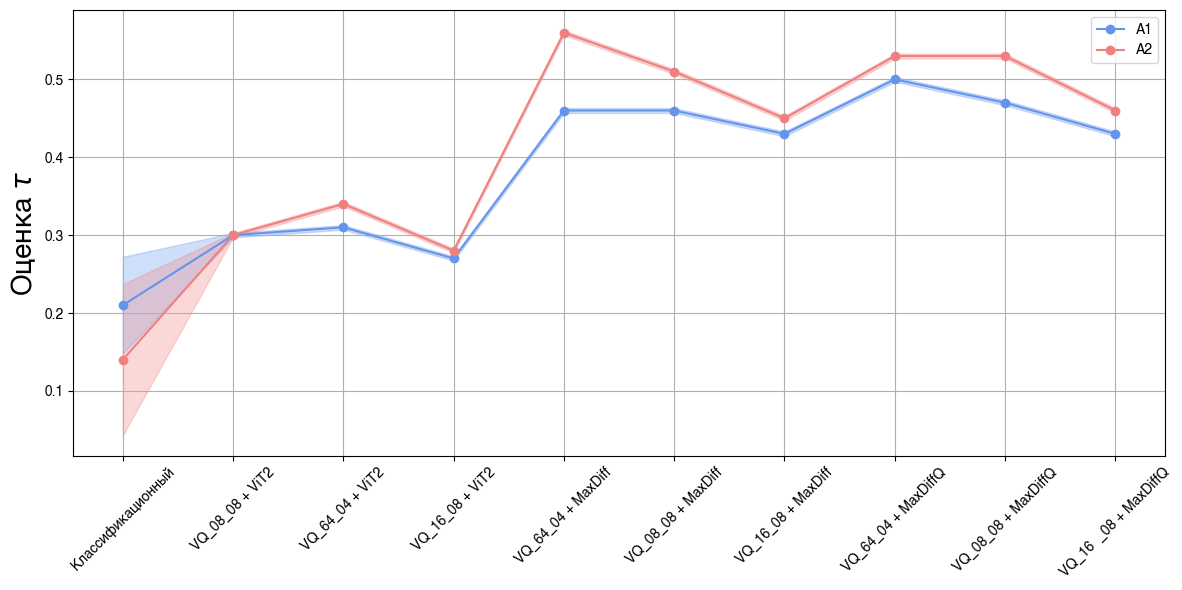

In [9]:
palette = {'A1': 'cornflowerblue', 'A2': 'lightcoral'}
models = data['Model'].unique()
x = range(len(models))

fig, ax = plt.subplots(figsize=(12, 6))

for dataset in ['A1', 'A2']:
    subset = data[data['Dataset'] == dataset].copy()
    tau = subset['Tau'].values
    ci_low = subset['CI_low'].values
    ci_high = subset['CI_high'].values

    # соединяет tau по моделям)
    ax.plot(x, tau, label=dataset, color=palette[dataset], marker='o')
    # заштрихованный CI
    ax.fill_between(
        x,
        ci_low,
        ci_high,
        alpha=0.3,
        color=palette[dataset]
    )


plt.xticks(rotation=45)
ax.set_xticks(x)
ax.set_xticklabels(models, )

ax.set_ylabel(r"Оценка $\tau$", fontsize=20)

ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


In [10]:
SELECTED_MODELS = ['VQ_64_04 + MaxDiff', 'VQ_64_04 + MaxDiffQ', 'VQ_08_08 + MaxDiff', 'VQ_08_08 + MaxDiffQ']

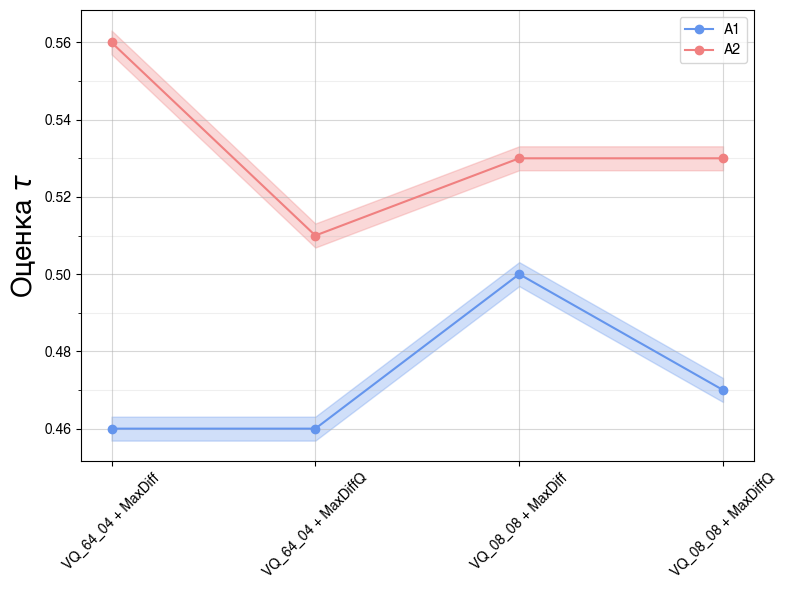

In [11]:
palette = {'A1': 'cornflowerblue', 'A2': 'lightcoral'}
x = range(len(SELECTED_MODELS))

fig, ax = plt.subplots(figsize=(8, 6))

for dataset in ['A1', 'A2']:
    subset = data[(data['Dataset'] == dataset) & data['Model'].isin(SELECTED_MODELS)].copy()
    tau = subset['Tau'].values
    ci_low = subset['CI_low'].values
    ci_high = subset['CI_high'].values

    # соединяет tau по моделям)
    ax.plot(x, tau, label=dataset, color=palette[dataset], marker='o')
    # заштрихованный CI
    ax.fill_between(
        x,
        ci_low,
        ci_high,
        alpha=0.3,
        color=palette[dataset]
    )


plt.xticks(rotation=45)
ax.set_xticks(x)
ax.set_xticklabels(SELECTED_MODELS)

major_ticks = np.arange(0.46, 0.56, 0.02)
minor_ticks = np.arange(0.46, 0.56, 0.01)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.set_ylabel(r"Оценка $\tau$", fontsize=20)

ax.legend()
plt.tight_layout()
plt.show()


## Оценка неопределенности порога $\beta$

Аналогично при выборе порога $\beta$ имеется ошибка, связанная с ограниченной выборкой примеров класса $H_1$. Как было описано выше,

$$
\mathbb{P} (\phi (x) \le \rho | H_1) \approx \frac{1}{|A|} \sum_{x \in A} \mathbb{I}[\phi(x) \leq \rho] \leq \beta.
$$



В этом случае, переобозначив в соответствии с принятыми в области статистики обозначениями,
$$
\beta = \mathbb{P} (\phi (x) \le \rho | H_1)
$$
$$
\hat{\beta} = \frac{1}{|A|} \sum_{x \in A} \mathbb{I}[\phi(x) \leq \rho]
$$
и мы фиксируем $\hat{\beta} = 0.20$.

Тогда абсолютно аналогично рассуждению про доверительные интервалы для $\tau$ можем подсчитать доверительные интервалы  для $\beta$, используя знания о
размерах датасетов
$|A_1|$ = 165, $|A_2| = 49$

Заметим, что эту оценку, в отличии от ошибки $\tau$, мы не можем уточнить взяв больший датасет $D$.

In [12]:
a1_beta_low, a1_beta_high = compute_ci(0.20, 165)
a2_beta_low, a2_beta_high = compute_ci(0.20, 49)

print(f'A1: [{a1_beta_low:.02f}, {a1_beta_high:.02f}]')
print(f'A2: [{a2_beta_low:.02f}, {a2_beta_high:.02f}]')

A1: [0.14, 0.26]
A2: [0.09, 0.31]


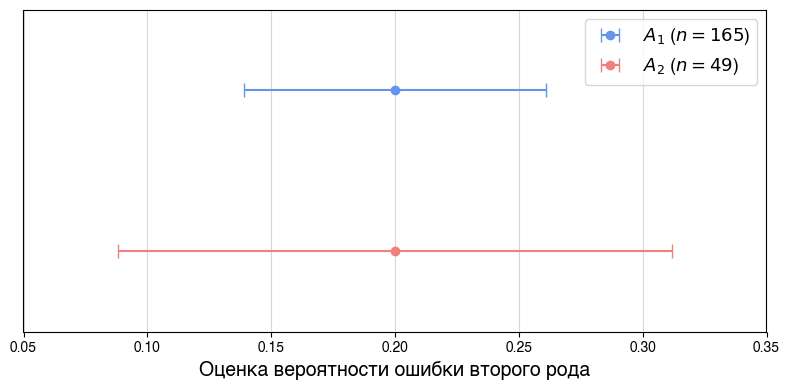

In [13]:
labels = [r'$A_1$ ($n = 165$)', r'$A_2$ ($n = 49$)']
intervals = [(a1_beta_low, a1_beta_high), (a2_beta_low, a2_beta_high)]
colors = ['cornflowerblue', 'lightcoral']

y_positions = [0.75, 0.25]

fig, ax = plt.subplots(figsize=(8, 4))
for i, ((low, high), y, color) in enumerate(zip(intervals, y_positions, colors)):
    ax.errorbar(
        0.20, y,
        xerr=[[0.20 - low], [high - 0.20]],
        fmt='o',
        color=color,
        capsize=5,
        label=labels[i]
    )

ax.set_ylim(0, 1)
ax.set_yticks([])
# ax.set_yticklabels(labels)

ax.set_xlim(0.05, 0.35)
ax.set_xlabel('Оценка вероятности ошибки второго рода', fontsize=14)
ax.grid(True, axis='x', alpha=0.5)
ax.legend(loc='upper right', fontsize=13)

plt.tight_layout()
plt.show()
